# Gene2vec: Neural word embeddings of amino acid sequences

## Overview

Gene2vec is an adaptation of the Word2vec model that aims to construct quasi-syntactic and semantic relationships  from amino acid sequence data. 

Word2vec is an extension upon the continuous Skip-gram model that allows for precise representation of semantic and syntactic word relationships. Additionally, Word2vec representations exhibit additive composability such that vector arithmetic can be performed on words. Mikolov et al. illustrate this behavior by noting that the resulting vector space representation of ```("Madrid" - "Spain" + "France")``` is closer to that of ```"Paris"``` than any other word.

We demonstrate the successful construction of such relationships from amino acid sequences by using them to perform some rudimentary protein classification.

## The Skip-gram Model

The Skip-gram model produces vector representations of words that can be used to predict words that are likely to be found in the same context. Formally, for a sequence of training words $w_1, w_2, ..., w_T$ and a context window of size $c$, the objective function is 

$$\frac{1}{T} \sum_{t=1}^T \sum_{-c\leq j\leq c,\; j \neq 0} \log p(w_{t+j}\mid w_t).$$

Mikolov et al. define $p(w_{t+j} \mid w_t)$ using the softmax function: 

$$p(w_O | w_I)=\frac{\exp{\left(v'_{w_O}{} ^\top v_{w_I}\right)}}{\sum_{w=1}^W \exp{\left( v'_{w} {} ^\top v_{w_t}\right)}}$$

where $v_w$ and $v'_w$ are the "input" and "output" vector representations of $w$, and $W$ is the number of words in the vocabulary.

<figure><img src='./res/skipgram.png' alt='Skip-gram Model' width="350"/> <figcaption><center><i>The Skip-gram model.</i></center></figcaption> </figure>

As shown in the figure, the output layer consists of $C$ multinomial distributions. Each output is computed as: 

$$p \left( w_{c,j} = w_{O,c} \mid w_I \right) = y_{c,j} = \frac{\exp{\left( u_{c,j} \right) }}{\sum_{j=1}^V \exp{\left( u_{j'} \right) }}$$

where 

* $w_{c,j}$ is the $j$th word on the $c$th panel of the output layer
* $w_{O,c}$ is the $c$th word in the output context words
* $w_I$ is the input word
* $y_{c,j}$ is the output of the $j$th node on the $c$th panel of the output layer
* $u_{c,j}$ is the net input of the $j$th node on the $c$th panel of the output layer

Rong notes that because output panels share the same weights, $u_{c,j}=u_j=\mathbf{v'}_{w_j}^\top \cdot \mathbf{h}$ for $c=1,2,...,C$, hidden layer weights $\mathbf{h}$, and the output vector of the $j$th word in the vocabulary $\mathbf{v'}_{w_j}$. 

### Hierarchical Softmax 
Mikolov notes that it is impractical to use the softmax function here, as the cost of computing $\nabla \log p(w_O \mid w_I)$ is proportional to $W$, which is often large. To remedy this, the hierarchical softmax function is used. Introduced by [Morin et al.](http://www.iro.umontreal.ca/~lisa/pointeurs/hierarchical-nnlm-aistats05.pdf) in 2005, the hierarchical softmax funciton reduces the required computation by only evaluating approximately $\log_2(W)$ nodes. 

A binary tree is used to represent the output layer with $W$ words as leaves and deach node representing the relative probablility of its child nodes. A random walk can then be used to assign probablities to words, as each word $w$ can be reached by some path from the root to $w$. From this we can define $p\left(w \mid w_I\right)$ using the hierarchical softmax as:

$$p\left(w \mid w_I\right) = \prod_{j=1}^{L(w)-1} \sigma \left( [[ n(w,j+1) = \text{ch}(n(w,j)) ]] \cdot v'_{n(w,j)} {}^\top v_{w_I} \right)$$

where 

* $n(w,j)$ the $j$th node on the path from the root to $w$
* $L(w)$ the length of the path
* ch$(n)$ an arbitrary fixed child of $n$
* $\sigma(x) = \left( 1 + \exp{(-x)} \right)^{-1}$
* $[[\cdot]] = \begin{cases} 1 &\text{if } x \text{ is true} \\ -1 &\text{otherwise} \end{cases}$

We can verify that the hierarchical softmax function is a valid probability density function by observing that 

$$\sum_{w=1}^W \prod_{j=1}^{L(w)-1} \sigma \left( [[ n(w,j+1) = \text{ch}(n(w,j)) ]] \cdot v'_{n(w,j)} {}^\top v_{w_I} \right) = \sum_{w=1}^W p(w \mid w_I) = 1.$$

### Negative Sampling
Skip-gram's performance was further improved with the advent of Word2vec replacing the hierarchical softmax function with a simplified variant of Noise Contrastive Estimation (NCE). 

Noise Contrasitive Estimation is an estimation principle for unnormalized statistical models stating that good models should be able to differentiate data from noise using a logistic regression. Skip-gram uses a simplified version of NCE to redefine the objective function as:


$$ p\left(w_O \mid w_I\right) = \log \sigma \left( v'_{w_O}{} ^\top v_{w_I} \right) + \sum_{i=1}^k \mathbb{E}_{w_i \sim P_n(w)}\left[ \log \sigma \left( -v'_{w_i}{} ^\top v_{w_I} \right) \right] $$


[Google](https://www.tensorflow.org/versions/r0.8/tutorials/word2vec/index.html) illustrates this simple substitution in the Continous Bag of Words (CBOW) model as shown below. Note the Skip-gram model is a reversed CBOW. 

<figure><img src='./res/nplm.png' alt='Hierarchical softmax to Noise Contrasitive Estimation transition' width="800"/> <figcaption><center><i>Hierarchical softmax to Noise Contrasitive Estimation transition.</i></center></figcaption> </figure>


### Loss function
The Skip-gram loss function $E$ is defined as: 

$$ \begin{align} E &= -\log p(w_{O,1}, w_{O,2},..., w_{O,C}\mid w_I) \\  &= -\log \prod_{c=1}^C \frac{\exp{\left(u_{c,j^*_c}\right)}}{\sum_{j'=1}^V \exp(u_{j'})} \\ &= -\sum_{c=1}^C u_{j^*_c} + C \cdot \log \sum_{j'=1}^V \exp \left( u_{j'} \right) \end{align}$$

where $j_c^*$ is the index of the $c$th output context word in the vocabulary. 

We can use this to calculate the prediction error for a node, $e_{c,j}$:

$$e_{c,j} = \frac{\partial E}{\partial u_{c,j}}= y_{c,j} - t_{c,j}$$

where $t_j = \begin{cases} 1 &\text{if the } j \text{th node is the actual output word} \\ 0 &\text{otherwise} \end{cases}$.

Rewriting the loss function to use NCE, we get:

$$E = -\log \sigma \left( \mathbf{v'}_{w_O} {}^\top  \mathbf{h} \right) - \sum _{w_i \in \mathcal{W}_{neg}} \log \sigma \left( \mathbf{v'}_{w_i} {}^\top  \mathbf{h} \right).$$

### Update Equations
The hidden layer is  $\mathbf{h} = {}^\top v_{w_I} = \frac{1}{C}W\cdot (v_{w_1} + v_{w_2} + ... + v_{w_c})$

We take the derivative of the loss function with regard to the net input of output unit $w_j$ to obtain our update equations
$$ \begin{align} \frac{\partial E}{\partial v'_{w_j}{}^\top v_{w_I}} &= \begin{cases} \sigma \left( v'_{w_j}{}^\top v_{w_I} \right) - 1 & \text{ if } w_j = w_O \\ \sigma \left( v'_{w_j}{}^\top v_{w_I} \right) & \text{ if } w_j \in \mathcal{W}_{\text{neg}} \end{cases}\\ &= \sigma \left( v'_{w_j}{}^\top v_{w_I} \right) - t_j \mid t_j \text{ the label for word } w_j \end{align} $$

### Learning Phrases
Skip-gram phrases are formed based on simple unigram and bigram counts. The phtase score function is defined as:

$$ \text{score}(w_i,w_j)=\frac{\text{count}(w_iw_j)-\delta}{\text{count}(w_i) \times \text{count}(w_j)} $$

where $\delta$ is used to prevent the formation of many phrases of infrequent words. 

## Word2Vec Examples

```
new york
              Word       Cosine distance
-----------------------------------------
       schenectady		0.587212
          brooklyn		0.553177
            newark		0.552684
            albany		0.538990
                ny		0.517134
                
darth vader
              Word       Cosine distance
-----------------------------------------
         palpatine		0.773569
           sidious		0.735910
            anakin		0.731247
         skywalker		0.699718
              sith		0.661552
```

### Visualization using principal component analysis
We can plot our relationships using the [$\texttt{visword2vec}$](https://gist.github.com/chezou/3899461aa550f73854a1) module. Visword2vec uses principal component analysis to perform dimensionality reduction on our high-dimensional word vectors. As a reminder, [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) is an orthogonal linear transformation of data to a new coordinate system such that the components are defined as
$$\begin{align}\mathbf{w}_{(1)} &= \underset{\Vert \mathbf{w} \Vert = 1}{\operatorname{\arg\,max}}\,\left\{ \sum_i \left(t_1\right)^2_{(i)} \right\} = \underset{\Vert \mathbf{w} \Vert = 1}{\operatorname{\arg\,max}}\,\left\{ \sum_i \left(\mathbf{x}_{(i)} \cdot \mathbf{w} \right)^2 \right\}\\ &= \underset{\Vert \mathbf{w} \Vert = 1}{\operatorname{\arg\,max}}\, \{ \Vert \mathbf{Xw} \Vert^2 \} = \underset{\Vert \mathbf{w} \Vert = 1}{\operatorname{\arg\,max}}\, \left\{ \mathbf{w}^T \mathbf{X}^T \mathbf{X w} \right\} \\ &= {\operatorname{\arg\,max}}\, \left\{ \frac{\mathbf{w}^T\mathbf{X}^T \mathbf{X w}}{\mathbf{w}^T \mathbf{w}} \right\} \end{align} $$

for the first vector, $\mathbf{w}_{(1)}$ in a matrix $\mathbf{X}$. Further components are defined by

$$\mathbf{w}_{(k)} = \underset{\Vert \mathbf{w} \Vert = 1}{\operatorname{arg\,max}} \left\{ \Vert \mathbf{\hat{X}}_{k} \mathbf{w} \Vert^2 \right\} = {\operatorname{\arg\,max}}\, \left\{ \tfrac{\mathbf{w}^T\mathbf{\hat{X}}_{k}^T \mathbf{\hat{X}}_{k} \mathbf{w}}{\mathbf{w}^T \mathbf{w}} \right\}$$

after subtracting the first $k-1$ components from $\mathbf{X}$:

$$\mathbf{\hat{X}}_{k} = \mathbf{X} - \sum_{s = 1}^{k - 1} \mathbf{X} \mathbf{w}_{(s)} \mathbf{w}_{(s)}^{\rm T}.$$

loading
loaded
[ 0.19379273  0.14548096]


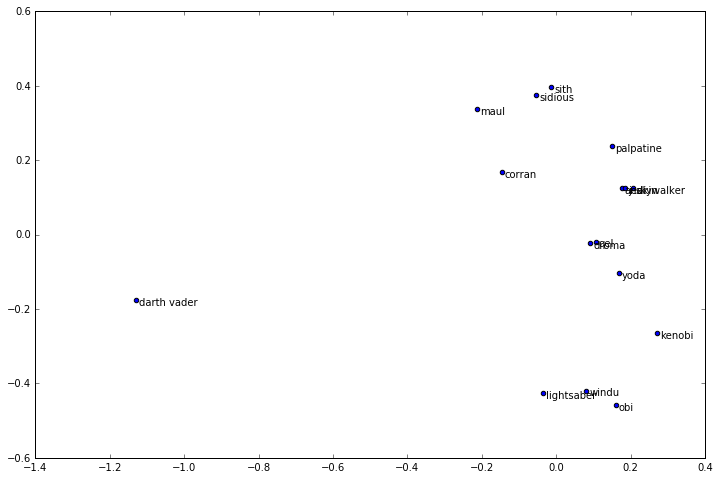

[ 0.13762598  0.11963841]


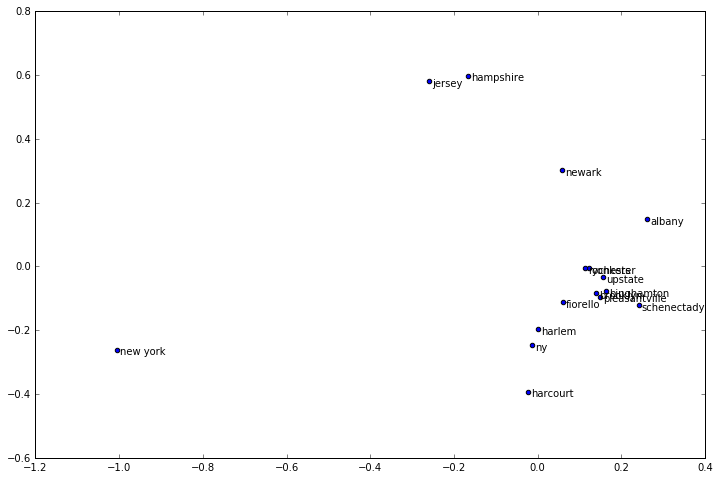

In [20]:
%matplotlib inline
import visword2vec
v = visword2vec.visWord2Vec('./res/text8.bin')
v.plot('darth vader')
v.plot('new york')

## Gene2Vec Examples
todo!

In [1]:
import visword2vec
visword2vec.visWord2Vec('protein_6-grams.bin').plot('AGVVGT')

loading


RuntimeError: Input file not found

|                       Amino Acid                       |         Formula         |                                                                                  Structure                                                                                  | [BCAA](https://en.wikipedia.org/wiki/Branched-chain_amino_acid) |
|:------------------------------------------------------:|:-----------------------:|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------:|:---------------------------------------------------------------:|
|    [Glycine](https://en.wikipedia.org/wiki/Glycine)    |  C$_{2}$H$_{5}$NO$_{2}$ |                                <img src='https://upload.wikimedia.org/wikipedia/commons/4/46/Glycin_-_Glycine.svg' alt='Glycine' width="60"/>                               |                                No                               |
|    [Alanine](https://en.wikipedia.org/wiki/Alanine)    |  C$_{3}$H$_{7}$NO$_{2}$ |                             <img src='https://upload.wikimedia.org/wikipedia/commons/9/90/L-Alanin_-_L-Alanine.svg' alt='Alanine' width="100"/>                             |                                No                               |
|     [Valine](https://en.wikipedia.org/wiki/Valine)     | C$_{5}$H$_{11}$NO$_{2}$ |                                <img src='https://upload.wikimedia.org/wikipedia/commons/f/f7/ValinenotatpH7.4.png' alt='Valine' width="100"/>                               |                               Yes                               |
|    [Leucine](https://en.wikipedia.org/wiki/Leucine)    | C$_{6}$H$_{13}$NO$_{2}$ |                                   <img src='https://upload.wikimedia.org/wikipedia/commons/4/4d/L-Leucine.svg' alt='Leucine' width="100"/>                                  |                               Yes                               |
| [Isoleucine](https://en.wikipedia.org/wiki/Isoleucine) | C$_{6}$H$_{13}$NO$_{2}$ | <img src='https://upload.wikimedia.org/wikipedia/commons/thumb/4/46/L-Isoleucin_-_L-Isoleucine.svg/232px-L-Isoleucin_-_L-Isoleucine.svg.png' alt='Isoleucine' width="100"/> |                               Yes           | 


<table align="center" class="RESULTS_TABLE" cellspacing="0" cellpadding="5"><tbody><tr><td bgcolor="#FFFFFF"><b>Native sequence: <a href="http://www.disprot.org/protein.php?id=DP00630">DP00630: Gamma-synuclein</a></b></td></tr><tr><td><br><blockquote><p class="sequence">
MDVFKKGFSI AKE<b>GVVGT</b>AVE KTKQGVTEAA EKTKEGVMYV GAKTKENVVQ SVTSVAEKTK - 60<br>EQANAVSEAV VSSVNTVATK TVEEAENIAV TSGVVRKEDL RPSAPQQEGE ASKEKEEVAE - 120<br>EAQSGGD</p></blockquote></td></tr></tbody></table>

<table align="center" class="RESULTS_TABLE" cellspacing="0" cellpadding="5"><tbody><tr><td bgcolor="#FFFFFF"><b>Native sequence: <a href="http://www.disprot.org/protein.php?id=DP00163">DP00163: Protein GIR2</a></b></td></tr><tr><td><br><blockquote><p class="sequence">
MDYKEEQKQE LEVLESIYPD ELRIINDEYP KIKFEVAIKL ELDTGDSTSV LTKEHTIIAE - 60<br>FKLPENYPDE PCLISLEAQE VALNDNEEDN EEDEDEVEYD DHGNKVLKKF ENLPDLISFK - 120<br>GYLPELTVQL ESQIETDMLL GMQMCFALIS SIKERCEQWY SEQLNKLEKQ YELEAQEREK - 180<br>KEQAKFHGTK VTRESYLEWR SKFRQELKLD ERDQVRRMKA HHGKLTGKQM FEQ<b>GVVGT</b>GD - 240<br>EYMEEDDASV DDVAKGLAKT EIANQ</p></blockquote></td></tr></tbody></table>

<table align="center" class="RESULTS_TABLE" cellspacing="0" cellpadding="5"><tbody><tr><td bgcolor="#FFFFFF"><b>Native sequence: <a href="http://www.disprot.org/protein.php?id=DP00664">DP00664: 18 kDa seed maturation protein</a></b></td></tr><tr><td><br><blockquote><p class="sequence">
MQGGKKAGES IKETATNIGA SAKAGMEKTK ATVQEKAERM TARDPVQKEL ATQKKEAKMN - 60<br>QAELDKQAAR QHNTAAKQSA TTAGHMGHGH HTTGTGTGTA TYSTTGEYGQ PMGAHQTSAM - 120<br>PGHGTGQPTG HVTE<b>GVVG</b>SH PIGTNRGPGG TATAHNTRAG GKPNDYGYGT GGT</p></blockquote></td></tr></tbody></table>


### Visualization of disordered protein 6-grams with Tensorflow

<figure><img src='./res/disprot.png' alt='Disordered Protein 6-grams' width="1000"/> <figcaption><center><i>Disordered Protein 6-grams.</i></center></figcaption> </figure>

## References
Rong, X. (2014). [word2vec Parameter Learning Explained](http://arxiv.org/pdf/1411.2738v3.pdf). arXiv:1411.2738 [cs].

T. Mikolov, I. Sutskever, K. Chen, G. Corrado, and J. Dean. [Distributed Representations of Words and Phrases and their Compositionality](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf). In Advances on Neural Information Processing Systems, 2013c

Asgari, E. and Mofrad, M.R.K. (2015) [Continuous Distributed Representation of Biological Sequences for Deep Proteomics and Genomics](http://arxiv.org/pdf/1503.05140.pdf). PLoS One, 10, e0141287.

"[Principal Component Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis)." Wikipedia. Wikimedia Foundation, n.d. Web. 20 Apr. 2016.

Morin, F., and Bengio, Y. 2005. [Hierarchical probabilistic neural network language model](http://www.iro.umontreal.ca/~lisa/pointeurs/hierarchical-nnlm-aistats05.pdf). In the international workshop on artificial intelligence and statistics, 246–252.

"[Vector Representations of Words](https://www.tensorflow.org/versions/r0.8/tutorials/word2vec/index.html)." Web log post. Tensorflow. Google